In [17]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.live import StockDataStream
from alpaca.data.requests import StockLatestQuoteRequest
from alpaca.data.requests import StockBarsRequest

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.live import CryptoDataStream

from alpaca.data.timeframe import TimeFrame

from datetime import datetime
from datetime import timedelta
from datetime import date
import time
import pandas as pd
import plotly.graph_objects as go
import math
import asyncio
import nest_asyncio

nest_asyncio.apply()

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

import os
FredApiKey = os.getenv("FRED_API_KEY")


from fredapi import Fred
fred = Fred(api_key=FredApiKey)


APIKEY = os.getenv("ALPACA_KEY")
APISECRET = os.getenv("ALPACA_SECRET_KEY")


In [18]:
StockDataStreamClient = StockDataStream(APIKEY, APISECRET)
StockHistoricalDataClient = StockHistoricalDataClient(APIKEY, APISECRET)
CryptoDataStreamClient = CryptoDataStream(APIKEY, APISECRET)
CryptoHistoricalDataClient = CryptoHistoricalDataClient(APIKEY, APISECRET)


In [19]:

today = date.today()
yesterday = today - timedelta(days=1)
dayInterval = TimeFrame.Day

years = 20
start = today - timedelta(days=365*years)


def getData(tickers, start, end, interval):
    requestparams = StockBarsRequest(
    symbol_or_symbols=tickers,
    timeframe=interval,
    start=start,
    end=end
    )
    bars = (StockHistoricalDataClient.get_stock_bars(requestparams)).df
    return bars

appleBarData = getData('AAPL', start, today, dayInterval)
appleBarData.info()
appleBarData.loc['AAPL']


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2305 entries, ('AAPL', Timestamp('2016-01-04 05:00:00+0000', tz='UTC')) to ('AAPL', Timestamp('2025-03-04 05:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         2305 non-null   float64
 1   high         2305 non-null   float64
 2   low          2305 non-null   float64
 3   close        2305 non-null   float64
 4   volume       2305 non-null   float64
 5   trade_count  2305 non-null   float64
 6   vwap         2305 non-null   float64
dtypes: float64(7)
memory usage: 215.6+ KB


,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,102.610,105.3680,102.000,105.35,71935339.0,351452.0,104.007250
2016-01-05 05:00:00+00:00,105.750,105.8500,102.410,102.71,58690536.0,321365.0,103.414304
2016-01-06 05:00:00+00:00,100.560,102.3700,99.870,100.70,71079827.0,409164.0,100.847762
2016-01-07 05:00:00+00:00,98.680,100.1300,96.430,96.45,85996453.0,462836.0,98.046209
2016-01-08 05:00:00+00:00,98.550,99.1100,96.760,96.96,75066292.0,419555.0,97.916490
...,...,...,...,...,...,...,...
2025-02-26 05:00:00+00:00,244.330,244.9800,239.130,240.36,44433564.0,557242.0,241.664944
2025-02-27 05:00:00+00:00,239.410,242.4600,237.060,237.30,41153639.0,503479.0,239.443587
2025-02-28 05:00:00+00:00,236.950,242.0900,230.200,241.84,56833360.0,572585.0,239.403148


## GET RATE DATA

In [20]:
def generateRates():
    data_part1 = fred.get_series('EFFR', observation_start='2000-01-01', observation_end='2023-01-01')

    data_part2 = fred.get_series('EFFR', observation_start='2023-01-01')

    df_part1 = data_part1.reset_index().rename(columns={'index': 'date', 0: 'value'})
    df_part2 = data_part2.reset_index().rename(columns={'index': 'date', 0: 'value'})

    rates = pd.concat([df_part1, df_part2]).drop_duplicates(subset=['date']).sort_values(by='date')
    
    rates.to_csv('RateData.csv', index=False)

In [21]:
def getRates():
    try:
        rates = pd.read_csv('RateData.csv', parse_dates=['date']).dropna(subset=['date'])
        rates = rates[['date', 'value']]
    except:
        generateRates()
        rates = pd.read_csv('RateData.csv', parse_dates=['date']).dropna(subset=['date'])
        rates = rates[['date', 'value']]
    
    rates['value'] = rates['value'].ffill()
    
    
    if rates['date'].iloc[-1] != yesterday:
    
        rates.to_csv('RateData.csv', index=False)
        update = fred.get_series('EFFR', observation_start=rates['date'].iloc[-1])
        rates = pd.concat([rates, update]).drop_duplicates(subset=['date']).dropna(subset=['date']).sort_values(by='date')
        rates = rates[['date', 'value']]
        rates.to_csv('RateData.csv', index=False)
    return rates

    
rates = getRates()

rates['date'].iloc[-1]

rates.tail()



,date,value
6419,2025-02-07,4.33
6420,2025-02-10,4.33
6421,2025-02-11,4.33
6422,2025-02-12,4.33
6423,2025-02-13,4.33


In [22]:
#def calcREMA(data, duration, weighting=None):
#    if weighting is None:
#        weighting = 2 / (duration + 1)
#    ema = []
#    for idx in range(len(data)):
#        if idx == 0:
#            # First EMA value: use the first data point directly
#            ema.append(data.iloc[idx])
#        elif idx < duration:
#            # Calculate EMA for initial period using a truncated range
#            temp = data.iloc[:idx + 1]  # Past values up to the current index
#            ema_temp = [temp.iloc[0]]  # Initialise EMA calculation
#            for j in range(1, len(temp)):
#                # Recursively calculate EMA for the truncated window
#                ema_temp.append((temp.iloc[j] * weighting) + (ema_temp[j - 1] * (1 - weighting)))
#            ema.append(ema_temp[-1])  # Use the last value as the EMA
#        else:
#            # Calculate EMA using a rolling window of 'duration'
#            temp = data.iloc[idx - duration + 1:idx + 1]  # Past 'duration' values
#            ema_temp = [temp.iloc[0]]  # Initialise EMA calculation
#            for j in range(1, len(temp)):
#                # Recursively calculate EMA for the rolling window
#                ema_temp.append((temp.iloc[j] * weighting) + (ema_temp[j - 1] * (1 - weighting)))
#            ema.append(ema_temp[-1])  # Use the last value as the EMA
#    ema = pd.DataFrame({'EMA': ema}, index=data.index)
#    return ema

def calcEMA(data, duration, weighting=None):
    # Default weighting for EMA is 2 / (duration + 1)
    if weighting is None:
        weighting = 2 / (duration + 1)

    ema = []  # Store the EMA values

    for idx in range(len(data)):
        if idx == 0:
            # Not enough data points for the rolling window, use raw data
            ema.append(data.iloc[idx])
        else:
            # Rolling EMA: calculate using the previous EMA
            new_ema = (data.iloc[idx] * weighting) + (ema[-1] * (1 - weighting))
            ema.append(new_ema)


    # Convert the EMA list to a pandas DataFrame with the same index as the input data
    ema_df = pd.DataFrame({'EMA': ema}, index=data.index)
    return ema_df



In [23]:
features = {'close': True, 'volume': True, 'EMA': 10, 'spy close': True, 'interest rate': True}

# false means that the feature is not included in the model

In [24]:
def featureScaling(data, inverse=False):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data
    

def getFeatures(ticker, years, features, scale=False, forTomorrow=False):
    raw = getData(ticker, today - timedelta(days=365*years+1), today, dayInterval).reset_index()
    data = pd.DataFrame()

    #feature fetching fucntions
    def close(data):
        data['close'] = raw['close'].copy()
        return data['close']
    def volume(data):
        data['volume'] = raw['volume'].copy()
        return data['volume']
    def EMA(data, duration):
        data['EMA'] = calcEMA(data['close'], duration).values
        return data['EMA']
    def spyClose(data):
        data['spy close'] = getData('SPY', today - timedelta(days=365*years+1), today, dayInterval)['close'].reset_index(drop=True).values
        return data['spy close']
    def interestRate(data):
        data['date_only'] = pd.to_datetime(data['timestamp'].dt.date)
        rates['date'] = pd.to_datetime(rates['date'])
        merged_data = pd.merge(data, rates, left_on='date_only', right_on='date', how='left')
        merged_data.drop(columns=['date', 'date_only'], inplace=True)
        merged_data['value'] = merged_data['value'].ffill()
        merged_data.rename(columns = {'value': 'interest rate'}, inplace=True)
        data = merged_data
        return data['interest rate']
    
    featureMap = {
        'close': close,
        'volume': volume,
        'EMA': EMA,
        'spy close': spyClose,
        'interest rate': interestRate
    }
    
    #feature fetching
    for feature, value in features.items():
        if value is True:
            data[feature]= featureMap[feature](raw)
        elif value is False:
            continue
        else:
            data['EMA'] = featureMap[feature](raw, features[feature])

    if forTomorrow==False:
        data['target close'] = raw['close'].shift(-1)
        data = data.iloc[:-1]
    elif forTomorrow==True:
        data = data.tail(1)

    if scale==True:
        scaleddata = featureScaling(data)
        scaleddata = pd.DataFrame(scaleddata, columns=data.columns)
        data = scaleddata

    
    data = pd.DataFrame(data)
    return data

# Example usage

testscale = getFeatures('AAPL', 1, features, True, True).tail()
#testscale = featureScaling(testscale)
print(testscale)

#print(getFeatures('AAPL', 1, features).head())

   close  volume  EMA  spy close  interest rate
0    0.0     0.0  0.0        0.0            0.0


{'RMSE': 2.790789810014325, 'R2': 0.9878256290103202}
     target close  prediction     error
0          167.45  167.816322 -0.366322
1          165.79  166.112847 -0.322847
2          173.57  173.540044  0.029956
3          173.50  173.876302 -0.376302
4          171.77  172.253269 -0.483269
..            ...         ...       ...
454        247.04  246.756866  0.283134
455        240.36  240.204052  0.155948
456        237.30  237.203081  0.096919
457        241.84  241.563839  0.276161
458        238.03  237.872838  0.157162

[459 rows x 3 columns]


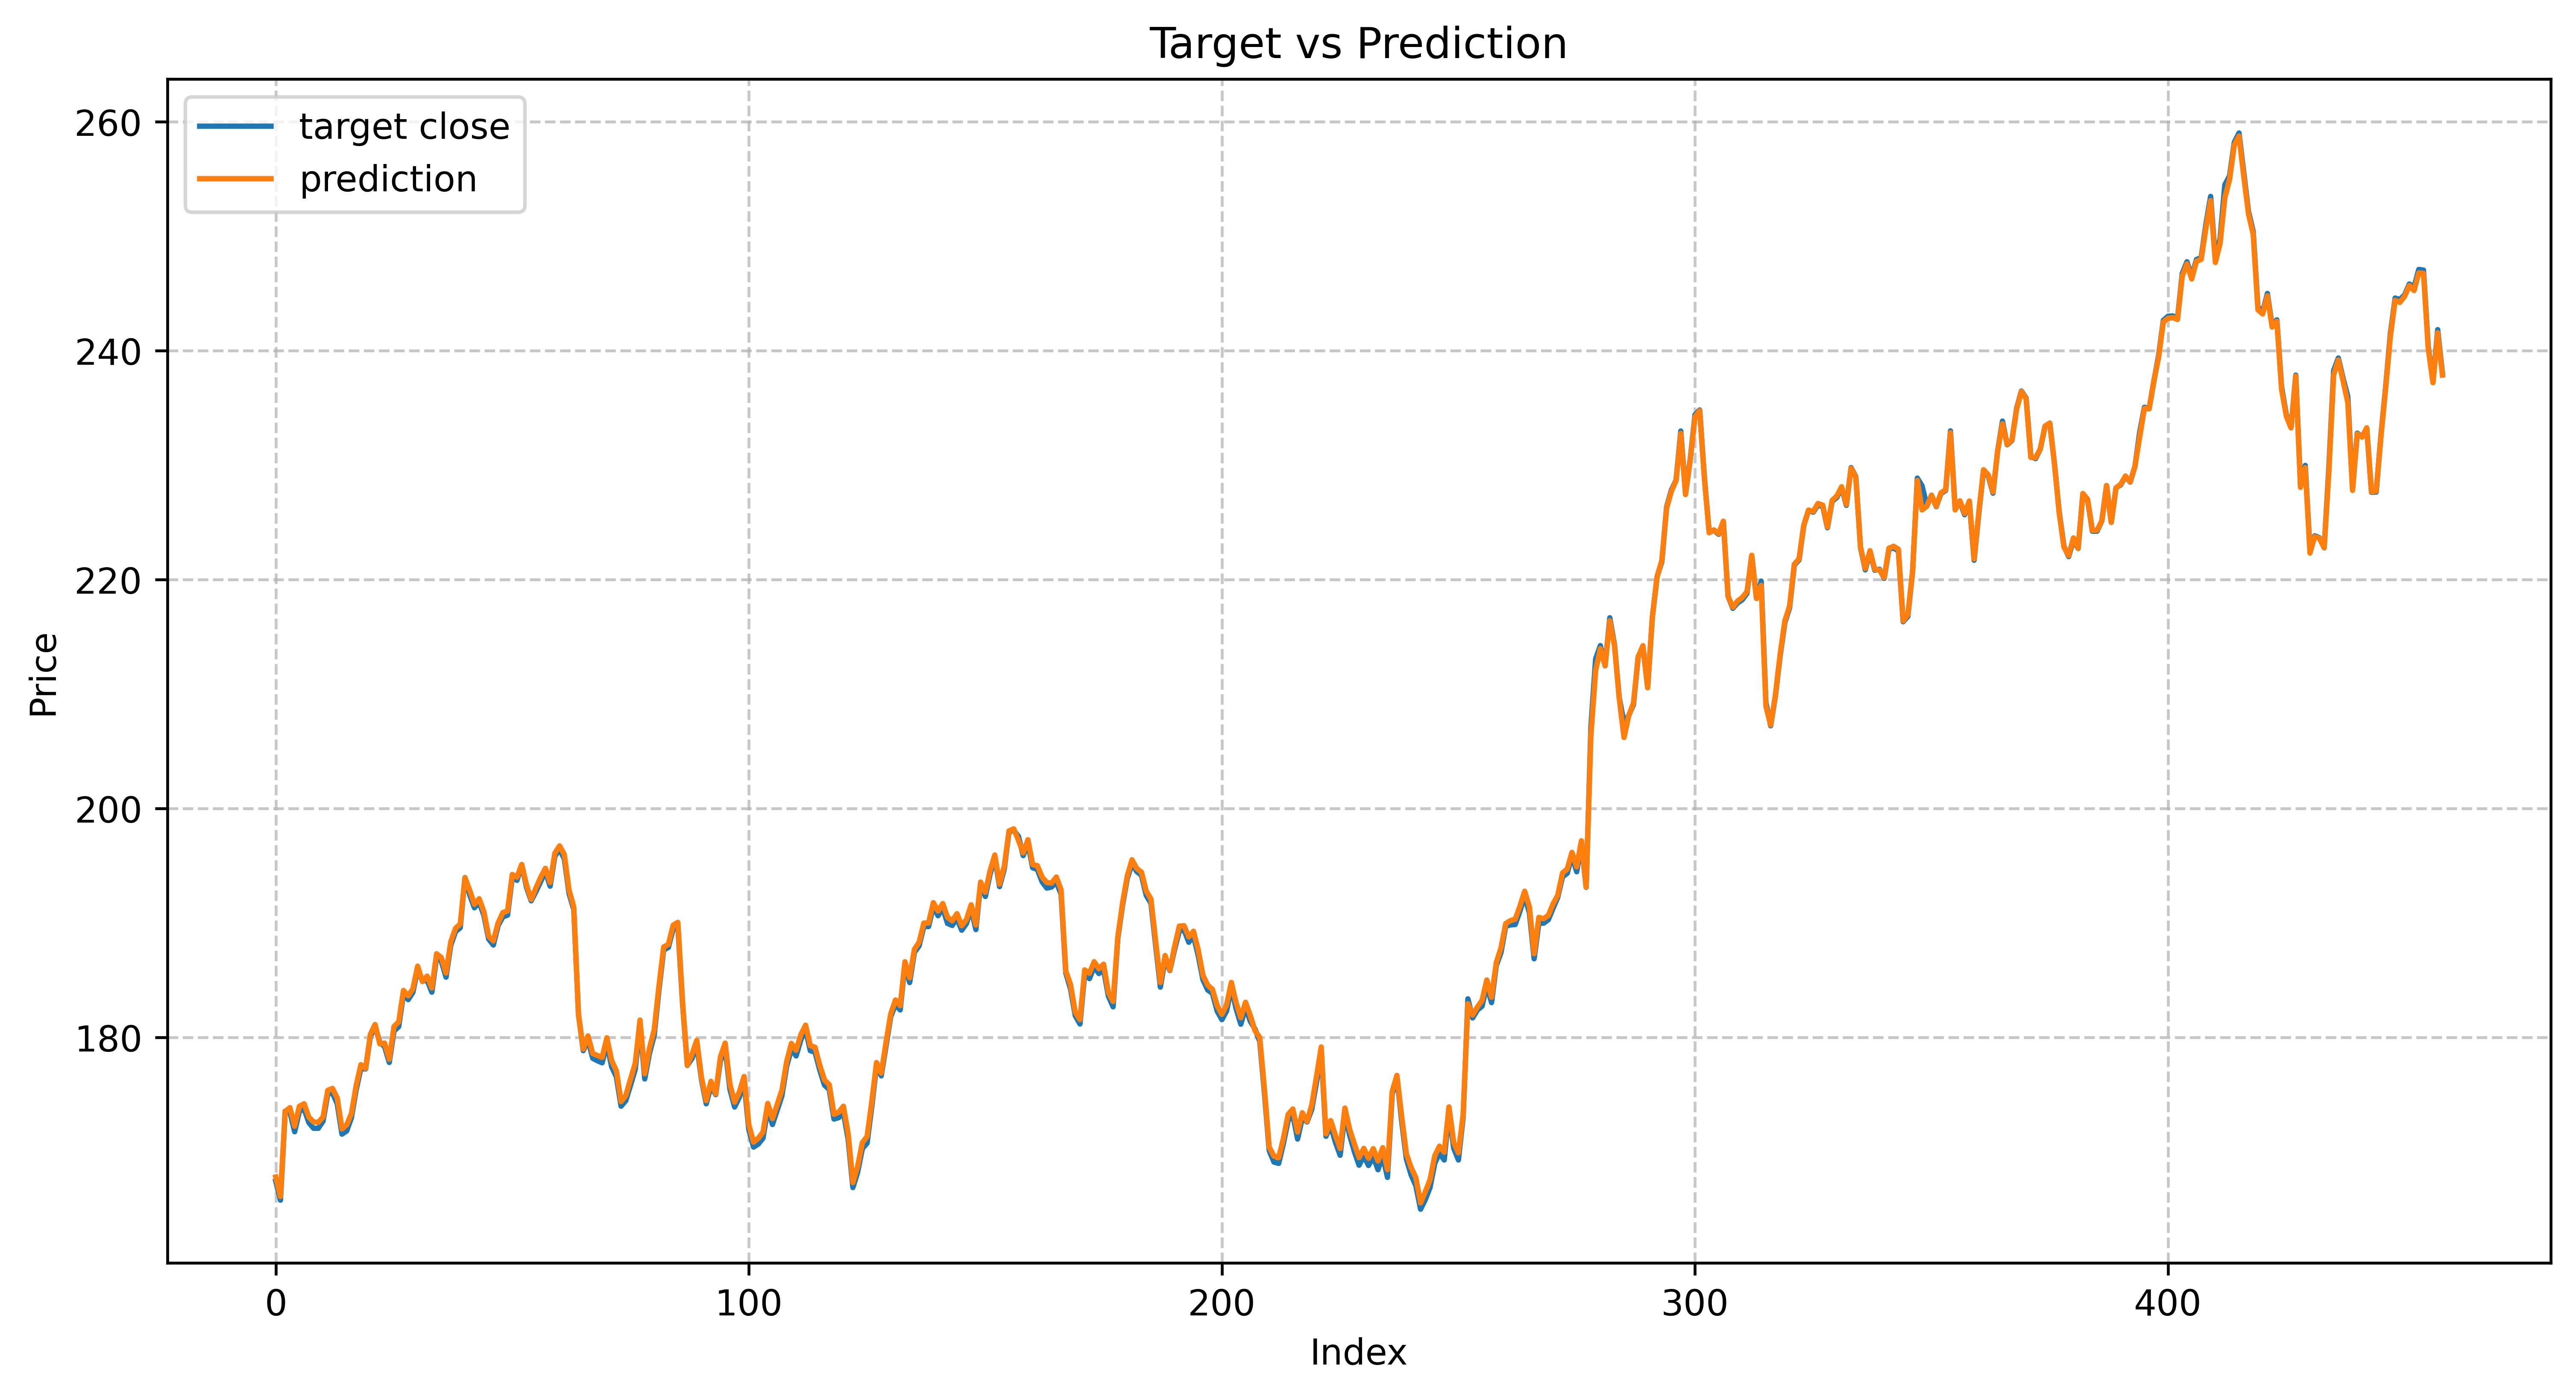

In [25]:
def OLSlinearRegression(ticker, years, features, scale=False, forTomorrow=False):
    pmatrix = getFeatures(ticker, years, features, scale, False)
    pmatrix.insert(0, 'ones', 1)
    testingmatrix = pmatrix.tail(len(pmatrix)//5)
    pmatrix = pmatrix.iloc[0:(len(pmatrix)-len(testingmatrix))]
    targetclose = pmatrix['target close'].values.reshape(-1, 1)
    pmatrix = pmatrix[['ones']+[key for key, value in features.items() if value is not False]]
    ptranspose = (pmatrix.T).values
    pmatrix = pmatrix.values
    ptemp = ptranspose @ pmatrix
    pinverse = np.linalg.inv(ptemp)
    beta = pinverse @ ptranspose @ targetclose
    targetclose = testingmatrix['target close'].values.reshape(-1, 1)
    testingmatrix = testingmatrix[['ones']+[key for key, value in features.items() if value is not False]]
    testingmatrix = testingmatrix.values
    prediction = testingmatrix @ beta
    data = pd.DataFrame({'target close': targetclose.flatten(), 'prediction': prediction.flatten()})
    data['prediction'] = data['prediction'].shift(-1)
    data = data.iloc[:-1]
    errors = data['target close'] - data['prediction']
    data['error'] = errors
    metrics = {'RMSE': math.sqrt(mean_squared_error(targetclose, prediction)), 'R2': r2_score(targetclose, prediction)}

    if forTomorrow==True:
        tmatrix = getFeatures(ticker, years, features, scale, True)
        tmatrix.insert(0, 'ones', 1)
        tomorrowPrice = tmatrix @ beta
        return tomorrowPrice, metrics, beta
    else:
        return data, metrics, beta



data, metrics, beta = OLSlinearRegression('AAPL', 10, features, False)

# Drop the last row where prediction is NaN


print(metrics)
print(data)

plt.figure(figsize=(12, 6), dpi=600)  # Increase figure size and resolution (dpi)
plt.plot(data['target close'], label='target close')
plt.plot(data['prediction'], label='prediction')
plt.legend()


# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Target vs Prediction")

# 
plt.show()



In [26]:
tomorrowPrice, _, _ = OLSlinearRegression('KO', 10, features, True, True)
print(tomorrowPrice)

          0
0  0.004461


In [27]:
def lassoRegression(ticker, years, features, llambda=0.1, scale=True, regularise=True, debug=False, forTomorrow=False, max_iterations=1000, tolerance=0.0000001):
    pmatrix = getFeatures(ticker, years, features, scale, False)
    pmatrix.insert(0, 'ones', 1)
    testingmatrix = pmatrix.tail(len(pmatrix)//5)
    pmatrix = pmatrix.iloc[0:(len(pmatrix)-len(testingmatrix))]
    targetclose = pmatrix['target close'].values.reshape(-1, 1)
    closesTemp = pd.DataFrame(pmatrix['target close'])
    pmatrix = pmatrix[[key for key, value in features.items() if value is not False]]
    ptranspose = (pmatrix.T).values
    pmatrix = pmatrix.values
    ptemp = ptranspose @ pmatrix
    pinverse = np.linalg.inv(ptemp)
    beta = pinverse @ ptranspose @ targetclose
    targetclose = testingmatrix['target close'].values.reshape(-1, 1)
    testingmatrix = testingmatrix[[key for key, value in features.items() if value is not False]]
    testingmatrix = testingmatrix.values
    prediction = testingmatrix @ beta
    data = pd.DataFrame({'target close': targetclose.flatten(), 'prediction': prediction.flatten()})
    data['prediction'] = data['prediction'].shift(-1)
    data = data.iloc[:-1]
    beta = pd.DataFrame(beta, columns=['beta'])
    
    lassoStuff = pd.DataFrame(pmatrix, columns=[key for key, value in features.items() if value is not False])
    lassoStuff = lassoStuff[[key for key, value in features.items() if value is not False]]
    lassoStuff['target close'] = closesTemp['target close']
    startweights = beta.values
    residuals = pd.DataFrame(index=range(len(lassoStuff)), columns=range(len(startweights)))
    
    for iteration in range(max_iterations):
        prevweights = startweights.copy()

        for idx, w in enumerate(startweights, start=0):
            for i in range(len(lassoStuff)): 
                residual = (lassoStuff.iloc[i, -1] - ((lassoStuff.loc[[i]].drop(columns=[lassoStuff.columns[idx], lassoStuff.columns[-1]])) @ (startweights[np.arange(len(startweights)) != idx])).values.item()).item()
                residuals.iloc[i, idx] = (residual)  

        for idx, w in enumerate(startweights, start=0):
            startweights[idx] = (lassoStuff.iloc[:, idx].T @ residuals.iloc[:, idx])/((lassoStuff.iloc[:, idx].T @ lassoStuff.iloc[:, idx])).item()

        if np.linalg.norm(startweights - prevweights) < tolerance:
            print(f"Converged in {iteration+1} iterations")
            break
        

    if regularise==True:
        for idx in range(len(startweights)):  
            startweights[idx] = (np.sign(startweights[idx]) * max(0, abs(startweights[idx]) - llambda)).item()

    #testingmatrix = testingmatrix.values   
    prediction = testingmatrix @ startweights
    data = pd.DataFrame({'target close': targetclose.flatten(), 'prediction': prediction.flatten()})
    data['prediction'] = data['prediction'].shift(+1)
    data = data.iloc[1:]
    errors = data['target close'] - data['prediction']
    data['error'] = errors
    metrics = {'RMSE': math.sqrt(mean_squared_error(targetclose, prediction)), 'R2': r2_score(targetclose, prediction)}
    

#    if forTomorrow==True:
#        #tmatrix = getFeatures(ticker, years, features, scale, True)
#        #tmatrix.insert(0, 'ones', 1)
#        #tomorrowPrice = tmatrix @ beta
#        return "not done yet"
#    else:
    if debug==True:
        return metrics, startweights, data
    elif debug==False:
        return data, metrics
    
    

In [28]:
features = {'close': False, 'volume': True, 'EMA': 10, 'spy close': True, 'interest rate': True}

metrics, updatedWeights, data = lassoRegression('AAPL', 10, features, 0.05, True, True, True, False) #scale, regularise, debug, forTomorrow

print(metrics)
print(updatedWeights)

Converged in 1 iterations
{'RMSE': 0.0977311044382411, 'R2': 0.9454812202419782}
[[-0.06972225]
 [ 0.89258929]
 [ 0.04448329]
 [-0.        ]]


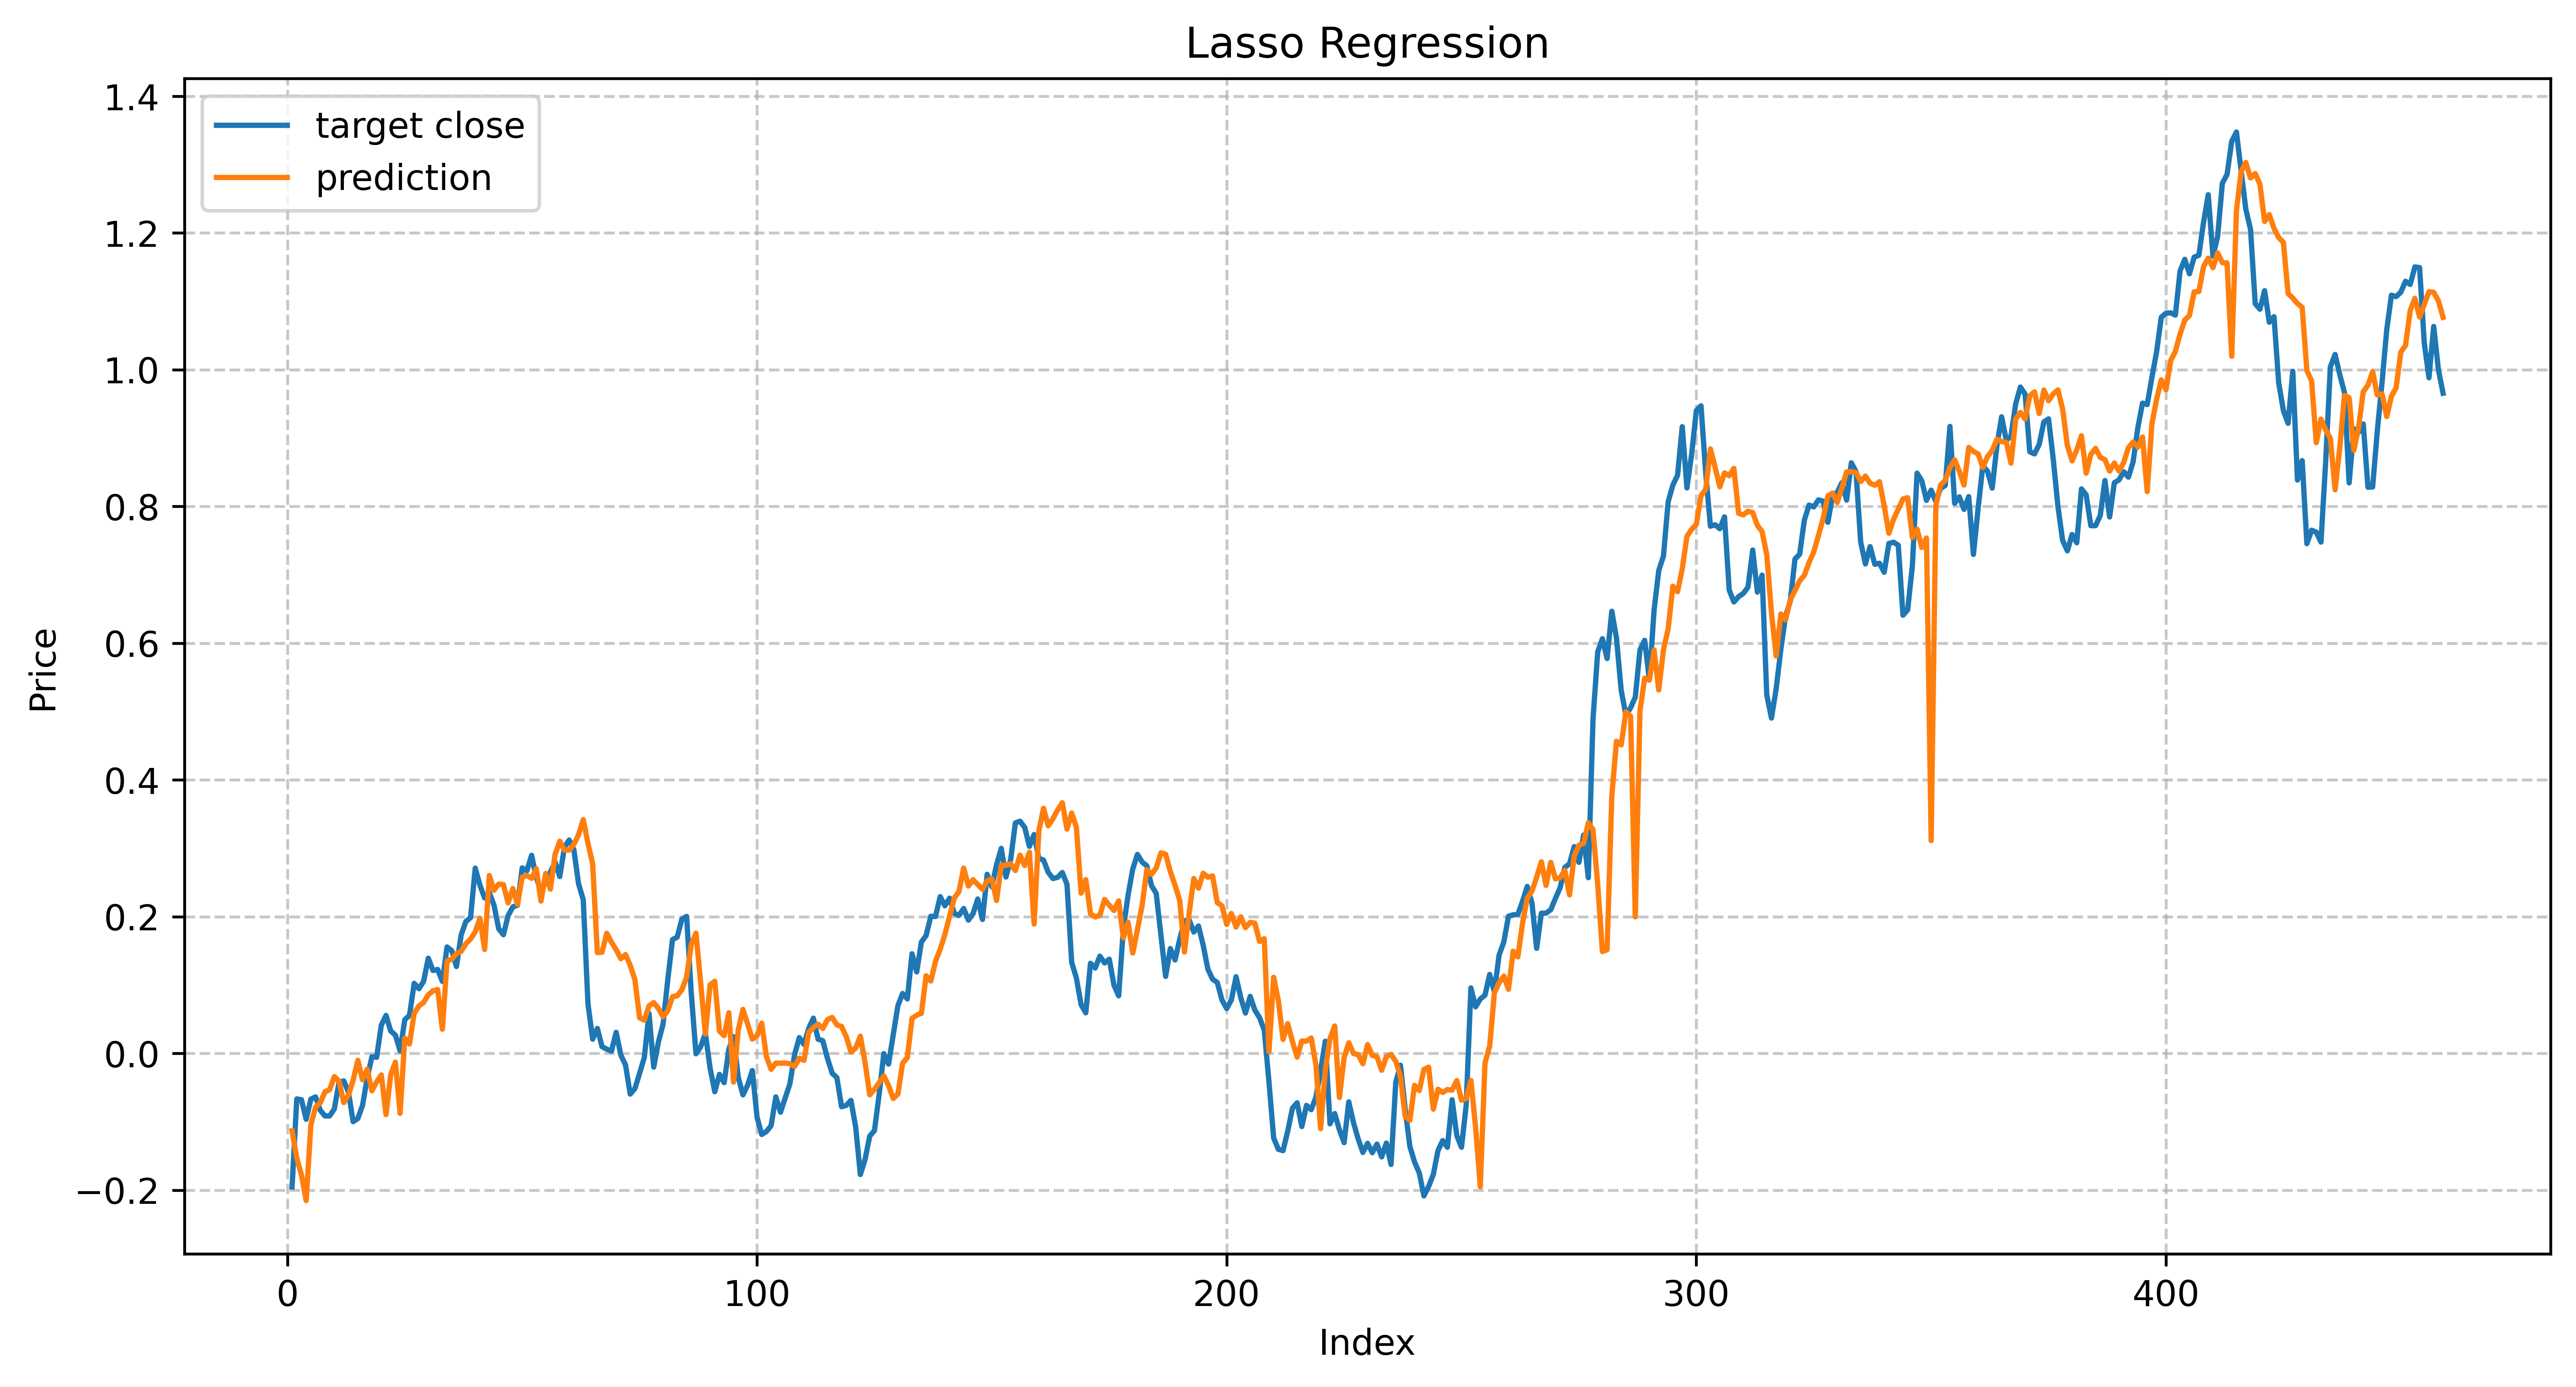

In [29]:
plt.figure(figsize=(12, 6), dpi=600)  # Increase figure size and resolution (dpi)
plt.plot(data['target close'], label='target close')
plt.plot(data['prediction'], label='prediction')
plt.legend()


# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Lasso Regression")

# 
plt.show()

In [30]:
def hestonPricer():
    
    return "not done yet"

## Graphing Function

In [31]:
def yearPricesGraph(tickers, years=1): 
    bars = getData(tickers, today-timedelta(days=365*years), today, dayInterval)
    barfig = go.Figure(data=[go.Candlestick(x=bars.loc[tickers].index, open=bars.loc[tickers, 'open'], high=bars.loc[tickers, 'high'], low=bars.loc[tickers, 'low'], close=bars.loc[tickers, 'close'])])
    barfig.update_layout(
        title = dict(text="$AAPL Stock Price"),
        yaxis = dict(
            title = dict(
                 text = "Price ($USD)"
            )
        )
    )
    return barfig


aaplfig = yearPricesGraph('AAPL', 10)
aaplfig.show()



In [32]:


latest_multisymbol_quotes = StockHistoricalDataClient.get_stock_latest_quote(latestquotes)


aaplprice = latest_multisymbol_quotes["AAPL"].ask_price


def latestQuote(tickers):
    latestQuotes = StockHistoricalDataClient.get_stock_latest_quote(tickers)
    return latestQuotes

print(latestQuote('AAPL'))


NameError: name 'latestquotes' is not defined

# real time data handling function

In [ ]:
async def quote_data_handler(data):
    # quote data will arrive here
    print(data)

In [ ]:


#async def runZoo(ticker):
#    await CryptoDataStreamClient.run(quote_data_handler, ticker)
#
#def runMain(ticker):
#    try:
#        asyncio.run(runZoo(ticker))
#    except KeyboardInterrupt:
#        print("Stream stopped by user.")
#
#runMain("FAKEPACA")

async def quote_data_handler(data):
    # quote data will arrive here
    print(data)
    if data:
        print("Data exists!")

CryptoDataStreamClient.subscribe_quotes(quote_data_handler, "BTC/USD")
try:
    CryptoDataStreamClient.run()
except KeyboardInterrupt:
    CryptoDataStreamClient.stop_ws()


In [ ]:


async def quote_data_handler(data):
    # quote data will arrive here
    print(data)

crypto_client.subscribe_quotes(quote_data_handler, "BTC/USD")

crypto_client.run()

time.sleep(5)

crypto_client.stop()
